# Machine Learning Boilerplate Workflow (K-Means Clustering Example)

## Define Problem

Goal: Cluster iris flowers into species-like groups based on features, without using labels (unsupervised learning)

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

## EDA

In [2]:
# Load dataset
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Series(iris.target, name="target")  # for evaluation/visualization only

X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [4]:
# just checking 
y.unique() # there are 3 classes

array([0, 1, 2])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


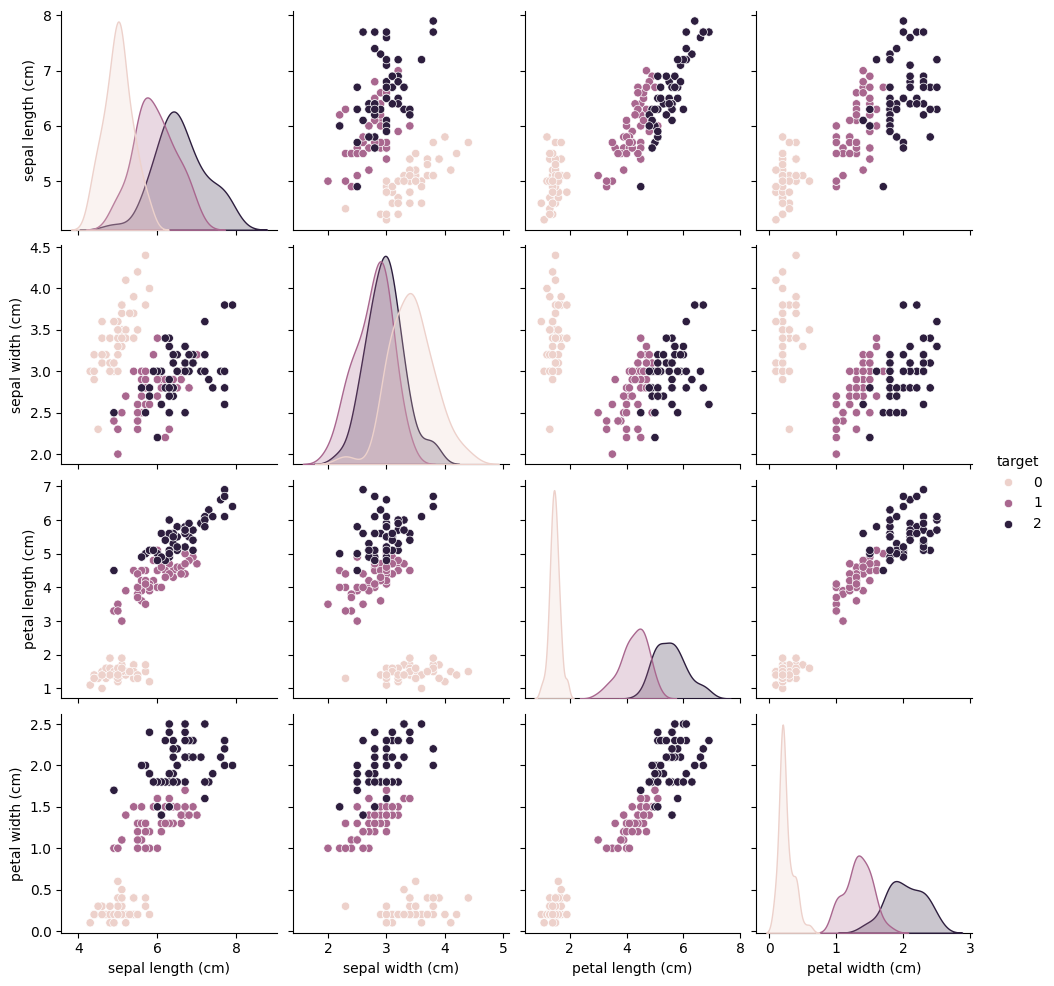

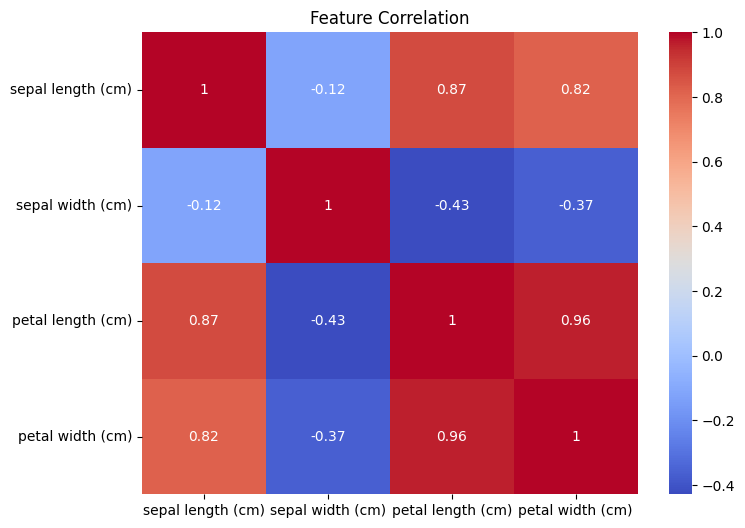

In [5]:
# Basic statistics
display(X.describe())

# Pairplot to visualize natural separations
sns.pairplot(pd.concat([X, y], axis=1), hue='target')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

## Data Preprocessing

In [6]:
# K-Means is distance based, so scaling is crucial

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Choose Number of Cluster 
- Elbow Method → Look for the “elbow” where inertia stops decreasing sharply.
- Silhouette Score → Measures cluster separation quality.

Interpretation:

- Elbow: Where the decrease in inertia slows down → optimal k
- Silhouette: Higher value = better defined clusters

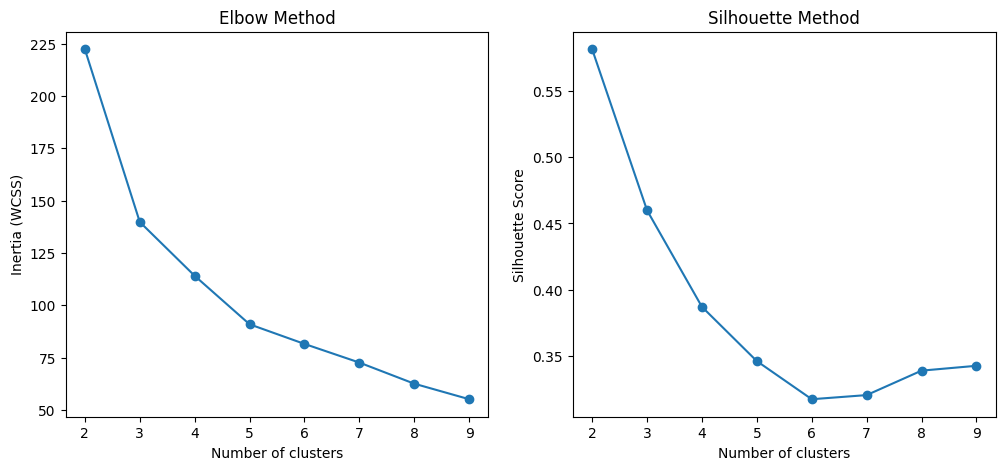

In [7]:
inertia = []
sil_scores = []

K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")

# Plot Silhouette
plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.show()

## Fit K-Means (Best K)

In [17]:
best_k = 2  # Chosen based on elbow/silhouette
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50)
clusters = kmeans.fit_predict(X_scaled)

# Attach clusters to dataframe
X['cluster'] = clusters
X['true_label'] = y
X.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),cluster,true_label
0,5.1,3.5,1.4,0.2,1,0
1,4.9,3.0,1.4,0.2,1,0
2,4.7,3.2,1.3,0.2,1,0
3,4.6,3.1,1.5,0.2,1,0
4,5.0,3.6,1.4,0.2,1,0


## Evaluate and Interpret Clusters

The crosstab creates a contingency table that compares each cluster (assigned by KMeans) with the true Iris species label:

    1. Rows: Clusters assigned by KMeans.
    2. Columns: Ground-truth class labels (0, 1, 2).
    3. Each cell: Number of samples in the cluster with that true label.

In [18]:
# Confusion matrix-like check
ct = pd.crosstab(X['cluster'], X['true_label'])
print("Cluster vs True Label:\n")
display(ct)

Cluster vs True Label:



true_label,0,1,2
cluster,,,
0,0,50,50
1,50,0,0


In [19]:
# Cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(centers, columns=iris.feature_names)
print("Cluster Centers (original scale):\n", centers_df)

Cluster Centers (original scale):
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0              6.262             2.872              4.906             1.676
1              5.006             3.428              1.462             0.246


## Visualization

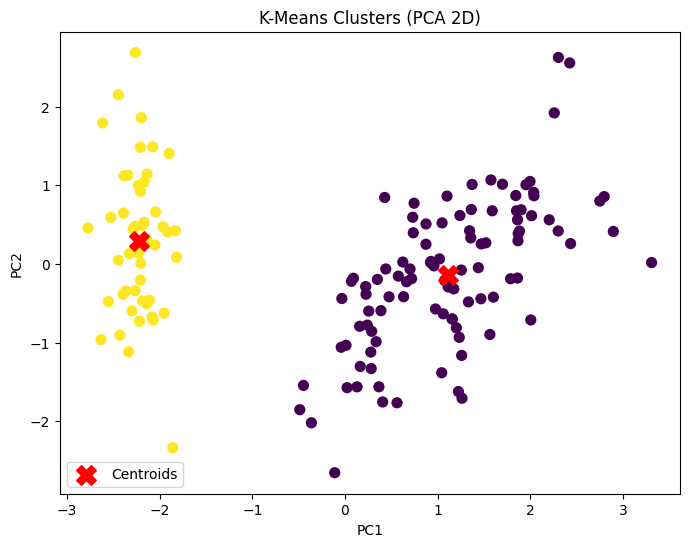

In [20]:
# PCA for 2D visualization
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis', s=50)
plt.scatter(pca.transform(kmeans.cluster_centers_)[:,0], 
            pca.transform(kmeans.cluster_centers_)[:,1], 
            c='red', marker='X', s=200, label='Centroids')
plt.title("K-Means Clusters (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.show()

## Bias-Variance / Stability Discussion

- Bias → Choosing too few clusters → underfits the natural group structure
- Variance → Choosing too many clusters → model sensitive to noise
- Stability → Run K-Means multiple times (n_init) to check if clusters are consistent

Inertia is the sum of squared distances from each sample to its nearest cluster center (centroid).

    - It measures how tightly the data points are clustered.
    - Lower inertia = denser clusters.
    - Inertia always decreases with more clusters (but too many clusters can mean overfitting).

Elbow method:

    - Plot inertia vs. k.
    - "Elbow" is the point where adding another cluster does not meaningfully reduce inertia—choose k here.

In [21]:
# Run multiple initializations
kmeans_multi = KMeans(n_clusters=best_k, n_init=50, random_state=42)
kmeans_multi.fit(X_scaled)
print("Inertia:", kmeans_multi.inertia_)

Inertia: 222.36170496502305


1. Automate and Compare Metrics for K Selection
Add a cluster evaluation dashboard, including silhouette, Calinski-Harabasz, and Davies-Bouldin scores:

**Interpretation:**

Look for the "elbow" or plateau in inertia, peak in silhouette/CH, and dip in DB for optimal K.

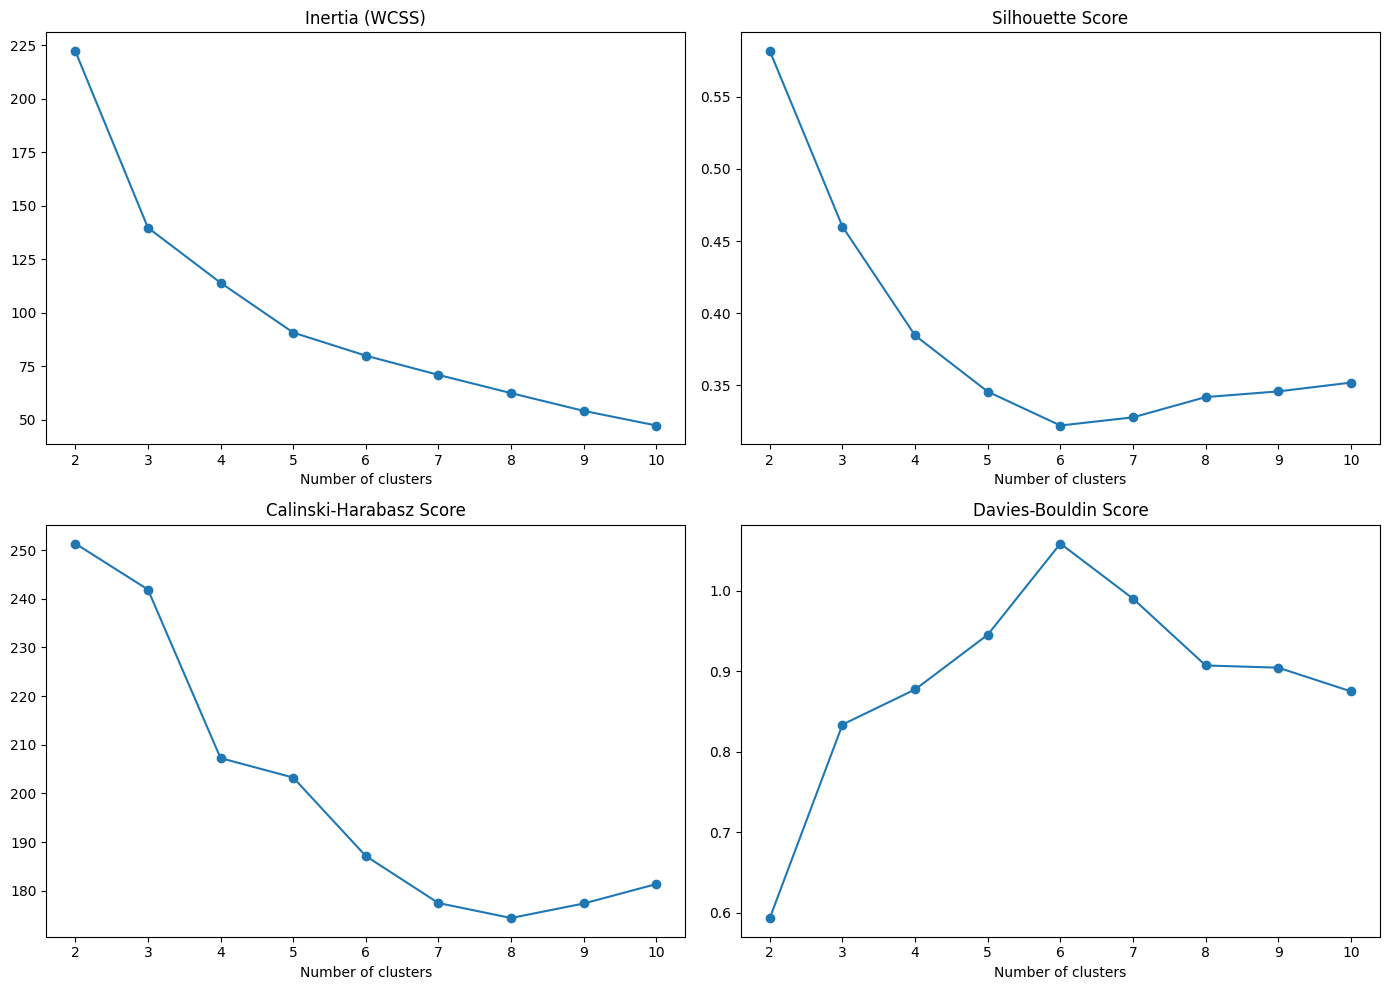

In [13]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

wcss = []
silhouette_scores = []
ch_scores = []
db_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    ch_scores.append(calinski_harabasz_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))

fig, axs = plt.subplots(2,2, figsize=(14,10))
axs[0,0].plot(K, wcss, marker='o'); axs[0,0].set_title("Inertia (WCSS)")
axs[0,1].plot(K, silhouette_scores, marker='o'); axs[0,1].set_title("Silhouette Score")
axs[1,0].plot(K, ch_scores, marker='o'); axs[1,0].set_title("Calinski-Harabasz Score")
axs[1,1].plot(K, db_scores, marker='o'); axs[1,1].set_title("Davies-Bouldin Score")
for ax in axs.ravel(): ax.set_xlabel("Number of clusters")
plt.tight_layout()
plt.show()


2. Cluster Assignment Diagnostics
Visualize cluster purity (crosstab heatmap):

- Pure diagonal = good alignment with true classes.
- Off-diagonal = mixed clusters; try adjusting K.

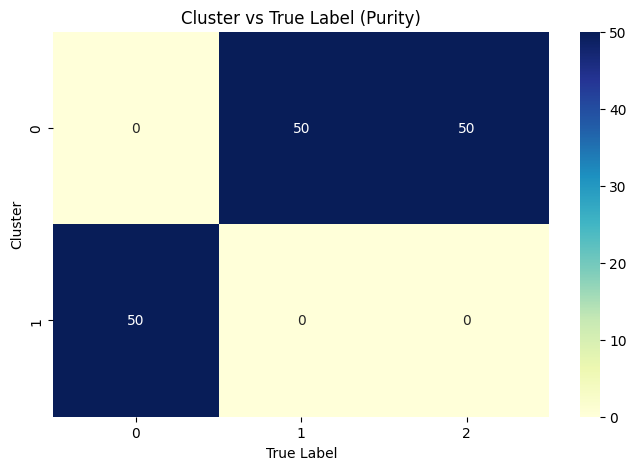

In [22]:
import seaborn as sns

ct = pd.crosstab(X['cluster'], X['true_label'])
plt.figure(figsize=(8, 5))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Cluster vs True Label (Purity)')
plt.ylabel('Cluster')
plt.xlabel('True Label')
plt.show()


3. Visualize Within-Cluster Feature Distributions
- Replace 'sepal length (cm)' for other features.
- Use these plots to see if clusters capture natural separation.

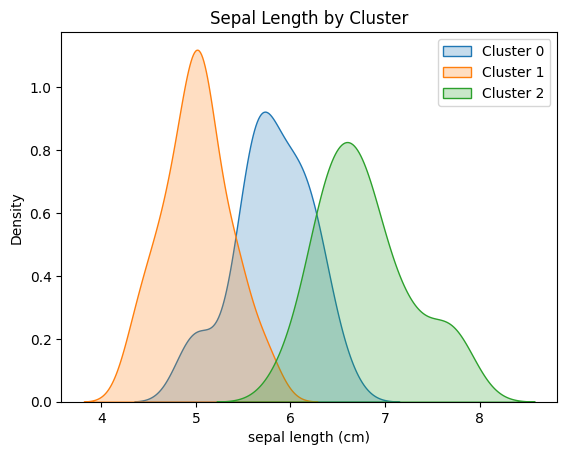

In [15]:
for c in range(best_k):
    sns.kdeplot(data=X[X['cluster'] == c], x='sepal length (cm)', fill=True, label=f'Cluster {c}')
plt.title('Sepal Length by Cluster')
plt.legend()
plt.show()

In [10]:
joblib.dump(kmeans, "kmeans_iris.pkl")
print("K-Means model saved as kmeans_iris.pkl")

K-Means model saved as kmeans_iris.pkl
